## Imports

In [1]:
from datetime import datetime
import numpy as np
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy as sp

## Load Data
- Variable: 2m dewpoint temperature ('d2m'), 2m temperature ('t2m'), Snowfall ('sf'), Total precipitation ('tp')
- Year: 2010-2020
- Month: March
- Days: 1-7
- Time: 0:00
    - TP is cumulative, but resets at 1:00 
    - TP for a single day given by 0:00
- Sub-region extraction: North 85°, West -170°, South 40°, East -50°

In [2]:
# Prepare model re-analysis data
era5_file = 'Datasets/7days.nc'
DS = xr.open_dataset(era5_file)

In [3]:
DS

<xarray.Dataset>
Dimensions:    (latitude: 451, longitude: 1201, time: 77)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.9 -169.8 ... -50.2 -50.1 -50.0
  * latitude   (latitude) float32 85.0 84.9 84.8 84.7 ... 40.3 40.2 40.1 40.0
  * time       (time) datetime64[ns] 2010-03-01 2010-03-02 ... 2020-03-07
Data variables:
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    sf         (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-14 15:58:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [4]:
# Convert total precipitation + snowfall from m to mm
DS.tp.values = DS.tp.values * 1000
DS.sf.values = DS.sf.values * 1000

## Convert to Dataframe
- Multi-indexed on lat/long and time (station/time)
- Appears to have a significant proportion of null values

In [5]:
ds = DS.to_dataframe()
ds

d2m  t2m  sf  tp
latitude longitude time                        
85.0     -170.0    2010-03-01  NaN  NaN NaN NaN
                   2010-03-02  NaN  NaN NaN NaN
                   2010-03-03  NaN  NaN NaN NaN
                   2010-03-04  NaN  NaN NaN NaN
                   2010-03-05  NaN  NaN NaN NaN
...                            ...  ...  ..  ..
40.0     -50.0     2020-03-03  NaN  NaN NaN NaN
                   2020-03-04  NaN  NaN NaN NaN
                   2020-03-05  NaN  NaN NaN NaN
                   2020-03-06  NaN  NaN NaN NaN
                   2020-03-07  NaN  NaN NaN NaN

[41707127 rows x 4 columns]

## Examine Null Values

In [6]:
# Look at proportion of nulls in overall dataset
ds.isna().sum()/ds.shape[0]

d2m    0.529175
t2m    0.529175
sf     0.529175
tp     0.529175
dtype: float64

In [7]:
# Plot distribution of null values for each station
nulls = []
for station, station_df in ds.groupby(level=0):
    null = station_df['d2m'].isna().sum()/station_df.shape[0]
    nulls.append(null)
    #     print('% Null:', null)
pd.Series(nulls).hist(color='g')
plt.title('Distribution of Null Values per Station')

Text(0.5, 1.0, 'Distribution of Null Values per Station')

- Largest bin appears to be stations w/ about 40-50% null values
- Few stations have 80-90% null values
- We can either:
    1.  Cut out stations w/ more than x% nulls 
        - Will eliminate a large portion of the data, but allow for interpolation of some missing values 
        - Generally a >30% null threshold is used, but if we want to include most stations, then >50% threshold
    2.  Cut out all nulls***
        - Eliminates high proportion of data
        - Much easier to work with
        - Good chunk of data measures oceans, but b/c datset is for LAND ONLY, these become null values
        - IGNORE NULLS

In [8]:
# Drop null values
ds_dropped = ds.dropna()
ds_dropped

d2m         t2m        sf         tp
latitude  longitude  time                                                   
83.099998 -74.500000 2010-03-01  238.204636  240.962753  0.172943   0.181377
                     2010-03-02  239.173843  241.769119  0.478275   0.481177
                     2010-03-03  240.479965  243.007828  0.181291   0.187375
                     2010-03-04  237.387268  240.255280  0.138354   0.142403
                     2010-03-05  237.077652  239.365234  0.125237   0.130411
...                                     ...         ...       ...        ...
40.000000 -74.099998 2020-03-03  277.663330  284.085541  0.000000   0.029977
                     2020-03-04  284.358826  285.435822  0.000000   3.569122
                     2020-03-05  273.478088  282.848083  0.000000   0.745002
                     2020-03-06  274.214783  279.185211  0.000000   0.139408
                     2020-03-07  275.415314  276.833313  0.000000  11.064131

[19636771 rows x 4 columns]

## Data Preprocessing

In [9]:
# From Feiccabrino et al (https://westernsnowconference.org/sites/westernsnowconference.org/PDFs/2007Feiccabrino.pdf)
# Remove all observations w/ less than 0.1 mm SWE *try TP (0.04) instead
ds_dropped = ds_dropped.loc[ds_dropped['tp'] >= 0.1]

In [10]:
ds_dropped

d2m         t2m        sf         tp
latitude  longitude  time                                                   
83.099998 -74.500000 2010-03-01  238.204636  240.962753  0.172943   0.181377
                     2010-03-02  239.173843  241.769119  0.478275   0.481177
                     2010-03-03  240.479965  243.007828  0.181291   0.187375
                     2010-03-04  237.387268  240.255280  0.138354   0.142403
                     2010-03-05  237.077652  239.365234  0.125237   0.130411
...                                     ...         ...       ...        ...
40.000000 -74.099998 2020-03-01  261.874878  273.275696  0.127621   0.140905
                     2020-03-04  284.358826  285.435822  0.000000   3.569122
                     2020-03-05  273.478088  282.848083  0.000000   0.745002
                     2020-03-06  274.214783  279.185211  0.000000   0.139408
                     2020-03-07  275.415314  276.833313  0.000000  11.064131

[10495408 rows x 4 columns]

In [11]:
# Construct target variable: snow fraction
ds_dropped['snow_frac'] = ds_dropped['sf']/ds_dropped['tp']

assert ds_dropped['snow_frac'].min() == 0

try:
    assert ds_dropped['snow_frac'].max() == 1
except:
    print("Invalid snow fraction values (> 1) detected")
    
    # Ensure no values above or below 1
    ds_dropped['snow_frac'] = ds_dropped['snow_frac'].map(lambda x: 1 if x > 1 else x)
    assert ds_dropped['snow_frac'].max() == 1
    print("Invalid snow fraction values fixed")

<ipython-input-11-5a48a693c87c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_dropped['snow_frac'] = ds_dropped['sf']/ds_dropped['tp']


Invalid snow fraction values (> 1) detected
Invalid snow fraction values fixed


<ipython-input-11-5a48a693c87c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_dropped['snow_frac'] = ds_dropped['snow_frac'].map(lambda x: 1 if x > 1 else x)


In [12]:
ds_dropped.drop_duplicates(inplace=True)

<ipython-input-12-ad86eba0ebce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_dropped.drop_duplicates(inplace=True)


In [13]:
# Convert dewpoint/air temperatures from Kelvin to degrees Celsius
ds_dropped['d2m'] = [i - 273.15 for i in ds_dropped['d2m']]
ds_dropped['t2m'] = [i - 273.15 for i in ds_dropped['t2m']]

<ipython-input-13-cf3d47ff7484>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_dropped['d2m'] = [i - 273.15 for i in ds_dropped['d2m']]
<ipython-input-13-cf3d47ff7484>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_dropped['t2m'] = [i - 273.15 for i in ds_dropped['t2m']]


In [14]:
ds_dropped

d2m        t2m        sf         tp  \
latitude  longitude  time                                                    
83.099998 -74.500000 2010-03-01 -34.945364 -32.187247  0.172943   0.181377   
                     2010-03-02 -33.976157 -31.380881  0.478275   0.481177   
                     2010-03-03 -32.670035 -30.142172  0.181291   0.187375   
                     2010-03-04 -35.762732 -32.894720  0.138354   0.142403   
                     2010-03-05 -36.072348 -33.784766  0.125237   0.130411   
...                                    ...        ...       ...        ...   
40.000000 -74.099998 2020-03-01 -11.275122   0.125696  0.127621   0.140905   
                     2020-03-04  11.208826  12.285822  0.000000   3.569122   
                     2020-03-05   0.328088   9.698083  0.000000   0.745002   
                     2020-03-06   1.064783   6.035211  0.000000   0.139408   
                     2020-03-07   2.265314   3.683313  0.000000  11.064131   

                                 snow_frac  
latitude  longitude  time                   
83.099998 -74.500000 2010-03-01   0.953500  
                     2010-03-02   0.993969  
                     2010-03-03   0.967534  
                     2010-03-04   0.971564  
                     2010-03-05   0.960322  
...                                    ...  
40.000000 -74.099998 2020-03-01   0.905721  
                     2020-03-04   0.000000  
                     2020-03-05   0.000000  
                     2020-03-06   0.000000  
                     2020-03-07   0.000000  

[10438310 rows x 5 columns]

## Examine Variable Distributions

In [15]:
ds_final = ds_dropped[['d2m', 't2m', 'snow_frac']]

In [16]:
ds_final

d2m        t2m  snow_frac
latitude  longitude  time                                       
83.099998 -74.500000 2010-03-01 -34.945364 -32.187247   0.953500
                     2010-03-02 -33.976157 -31.380881   0.993969
                     2010-03-03 -32.670035 -30.142172   0.967534
                     2010-03-04 -35.762732 -32.894720   0.971564
                     2010-03-05 -36.072348 -33.784766   0.960322
...                                    ...        ...        ...
40.000000 -74.099998 2020-03-01 -11.275122   0.125696   0.905721
                     2020-03-04  11.208826  12.285822   0.000000
                     2020-03-05   0.328088   9.698083   0.000000
                     2020-03-06   1.064783   6.035211   0.000000
                     2020-03-07   2.265314   3.683313   0.000000

[10438310 rows x 3 columns]

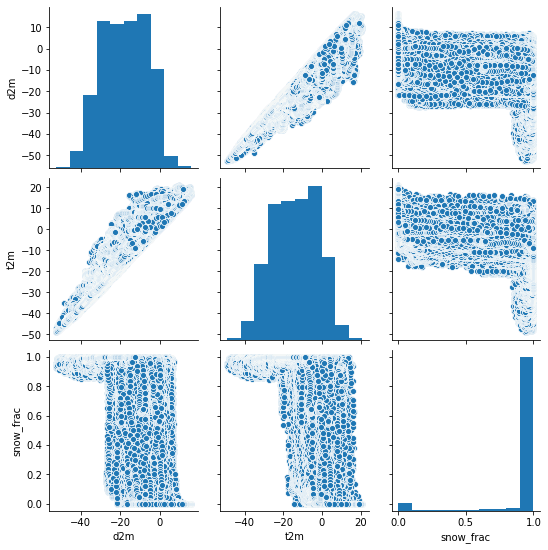

In [17]:
sns.pairplot(ds_final)

Neither d2m nor t2m appear to show a linear relationship with snow fraction.

Text(0.5, 1.0, 'Air Temperature')

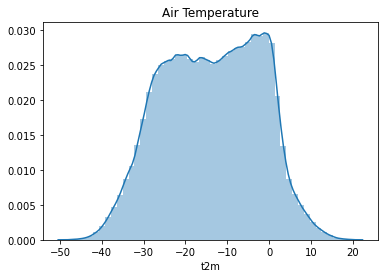

In [18]:
sns.distplot(ds_final['t2m'])
plt.title('Air Temperature')

In [19]:
sns.distplot(ds_final['d2m'])
plt.title('Dew Point Temperature')

Text(0.5, 1.0, 'Dew Point Temperature')

## Correlation Matrix

In [21]:
corr_matrix = ds_final.corr()

In [22]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

<AxesSubplot:>

## Train-Test Split
- Split by year:
    - 2010-2020
    - Latest 30% of data points for testing
    - Oldest 70% of data points for training

In [23]:
ds_ = ds_final.reset_index()
ds_['time'] = pd.to_datetime(ds_['time'])
ds_train = ds_[ds_['time'].dt.year <= 2018].set_index(['latitude', 'longitude', 'time'])
ds_test = ds_[ds_['time'].dt.year > 2018]

In [24]:
ds_train

d2m        t2m  snow_frac
latitude  longitude  time                                       
83.099998 -74.500000 2010-03-01 -34.945364 -32.187247   0.953500
                     2010-03-02 -33.976157 -31.380881   0.993969
                     2010-03-03 -32.670035 -30.142172   0.967534
                     2010-03-04 -35.762732 -32.894720   0.971564
                     2010-03-05 -36.072348 -33.784766   0.960322
...                                    ...        ...        ...
40.000000 -74.099998 2017-03-03  -7.380499   5.685297   0.000000
                     2017-03-04 -10.216956   1.848718   0.046980
                     2018-03-02   5.769647   7.737970   0.000000
                     2018-03-03  -0.216437   2.606897   0.315213
                     2018-03-04  -0.999396   5.770227   0.452269

[8498265 rows x 3 columns]

## Thresholding 

Text(0.5, 1.0, 'Snow Fraction')

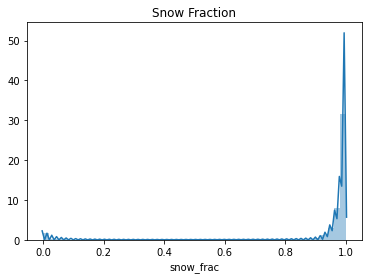

In [20]:
sns.distplot(ds_final['snow_frac'])
plt.title('Snow Fraction')

## Data Transformation

In [25]:
y_train = ds_train['snow_frac']
y_test = ds_test['snow_frac']

X_train = ds_train.drop(['snow_frac'], axis=1)
X_test = ds_test.drop(['snow_frac'], axis=1)

In [26]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer().fit(np.array(X_train))

X_train_norm = pt.transform(np.array(X_train))
X_test_norm = pt.transform(np.array(X_test))

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
X_train_norm_df = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_train_norm_df['snow_frac'] = list(y_train)

In [ ]:
X_train_norm_df

## Linear Regression

In [ ]:
import statsmodels.formula.api as smf
reg = smf.ols(formula='snow_frac ~ t2m + d2m', data=X_train_norm_df).fit()
reg.summary()

Poor coefficient of determination (0.3-0.4) for bivariate model

In [ ]:
pred_val = reg.fittedvalues.copy()
true_val = X_train_norm_df['snow_frac'].values.copy()
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(pred_val, residual, marker='o', edgecolor='black', linewidth=0.3)
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.title("Fitted vs Residuals Plot")

Clear trend in fitted vs. residuals plot indicates heteroscedasticity (violates an assumption of linear regression)

In [ ]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
print("Coefficient of Determination:", r**2)

Q-Q plot shows the residuals are normally distributed

In [ ]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(X_train_norm_df['d2m'], residual, marker='o', edgecolor='black', linewidth=0.3)
plt.xlabel('d2m')
plt.ylabel('Residuals')

In [ ]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(X_train_norm_df['t2m'], residual, marker='o', edgecolor='black', linewidth=0.3)
plt.xlabel('t2m')
plt.ylabel('Residuals')

Both plots show that the residuals are not independent of each other.
Overall, linear regression DOES NOT appear to be an appropriate model for predicting snow fraction from air or dewpoint temperature.